In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lorenzodelmedico","key":"2e8bbd994a00cda8a968355dd7bc542e"}'}

In [7]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 72 Jun  8 12:14 kaggle.json


In [8]:

!pip install -q kaggle
!mkdir -p ~/.kaggle #Create the directory

In [ ]:
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

!unzip cartoon-faces-googles-cartoon-set.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: cartoonset100k_jpg/0/cs1300577729877487775.jpg  
  inflating: cartoonset100k_jpg/0/cs13005824363048622189.jpg  
  inflating: cartoonset100k_jpg/0/cs13005883398263816987.jpg  
  inflating: cartoonset100k_jpg/0/cs13006276546835152540.jpg  
  inflating: cartoonset100k_jpg/0/cs13006288500248540523.jpg  
  inflating: cartoonset100k_jpg/0/cs13006309832389618725.jpg  
  inflating: cartoonset100k_jpg/0/cs13006313854206388872.jpg  
  inflating: cartoonset100k_jpg/0/cs13006446037327262211.jpg  
  inflating: cartoonset100k_jpg/0/cs13006450541850053266.jpg  
  inflating: cartoonset100k_jpg/0/cs13006882622877514260.jpg  
  inflating: cartoonset100k_jpg/0/cs13007035309146245895.jpg  
  inflating: cartoonset100k_jpg/0/cs13007530126619541763.jpg  
  inflating: cartoonset100k_jpg/0/cs13007692152771198822.jpg  
  inflating: cartoonset100k_jpg/0/cs13007732070140725582.jpg  
  inflating: cartoonset100k_jpg/0/cs13007

In [3]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from PIL import Image
import numpy as np

In [3]:
!ls

cartoon-faces-googles-cartoon-set.zip  drive	    sample_data
cartoonset100k_jpg		       kaggle.json


In [4]:
# Function to process a single image
def process_image(img_path):
    label = os.path.basename(os.path.dirname(img_path))
    img = Image.open(img_path)
    resized_image = img.resize((50,50))
    img_array = np.array(resized_image)
    
    return img_array, label

In [5]:
data_dir = "./cartoonset100k_jpg/"
img_dir = data_dir + "0/cs11502169095236683120.jpg"

In [6]:
image = Image.open(img_dir)

# Get the size of the image
width, height = image.size

# Print the image size
print("Image Size (Width x Height): {} x {}".format(width, height))

Image Size (Width x Height): 500 x 500


In [7]:
#Initialize empty lists to store the image vectors and their corresponding labels:
image_vectors = []
labels = []

In [8]:
total_files = sum([len(files) for _, _, files in os.walk(data_dir)])
total_dir = sum([len(dir) for _, dir, files in os.walk(data_dir)])

In [9]:
print(total_dir)

10


In [10]:
with ThreadPoolExecutor() as executor:
    futures = []
    for root, dirs, files in tqdm(os.walk(data_dir), desc="Processing images"):
        for file in files:
            img_path = os.path.join(root, file)
            futures.append(executor.submit(process_image, img_path))

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing progress"):
        flattened_img, label = future.result()
        image_vectors.append(flattened_img)
        labels.append(label)


Processing images: 11it [00:11,  1.06s/it]
Processing progress: 100%|██████████| 100000/100000 [01:25<00:00, 1169.56it/s]


In [11]:
len(image_vectors)

100000

In [ ]:
max_chunk_size = 1000

In [ ]:
# Split the array into smaller chunks
chunks = [image_vectors[i:i+max_chunk_size] for i in range(0, len(image_vectors), max_chunk_size)]

In [ ]:
# Print the number of chunks created
print("Total chunks:", len(chunks))

In [12]:
# Reshape images to a common shape
test_resized_image = [np.reshape(img, (50, 50, 3)) for img in image_vectors]

In [13]:
import matplotlib.pyplot as plt

In [14]:
def pca_compress_decompress(X, n_components=30):

    # Convert the list of arrays to a single NumPy array
    X_concatenated = np.concatenate(X)
    print(X_concatenated.shape)

    # Flatten the images into vectors
    X_concatenated = X_concatenated.reshape(X_concatenated.shape[0], -1)

    # Convert data to float and scale it between 0 and 1
    X_concatenated = X_concatenated.astype(float) / 255.0

    # Calculate the mean vector
    mean_vector = np.mean(X_concatenated, axis=0)

    # Subtract the mean vector from the data
    X_centered = X_concatenated - mean_vector

    
    # calculating the covariance matrix of the mean-centered data.
    cov_mat = np.cov(X_centered , rowvar = False)

    if cov_mat.ndim == 0:
      # Handle the case of scalar covariance matrix
      print("Cannot perform PCA compression. No variation in the data.")
      return X
    

    #Calculating Eigenvalues and Eigenvectors of the covariance matrix
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    
    sorted_eigenvalue = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigen_vectors[:,sorted_index]


    # select the first n eigenvectors, n is desired dimension
    # of our final reduced data.
    eigenvector_subset = sorted_eigenvectors[:,0:n_components]

    #Transform the data 
    X_reduced = np.dot(eigenvector_subset.transpose(),X_centered.transpose()).transpose()

    # Reconstruct the data from the projected space
    X_reconstructed = np.dot(X_reduced, eigenvector_subset.T) + mean_vector


    return X_reconstructed

In [15]:
n_components = 50
X_reconstructed = pca_compress_decompress(test_resized_image, n_components=n_components)

(5000000, 50, 3)


In [16]:
print(X_reconstructed.shape)

(5000000, 150)


In [17]:
# Reshape the reconstructed data into images
X_reconstructed = X_reconstructed.reshape((-1, 50, 50,3))

In [18]:
X_reconstructed.shape

(100000, 50, 50, 3)

In [19]:
# Display the generated images in a grid
num_images = 12
num_rows = num_images // 4

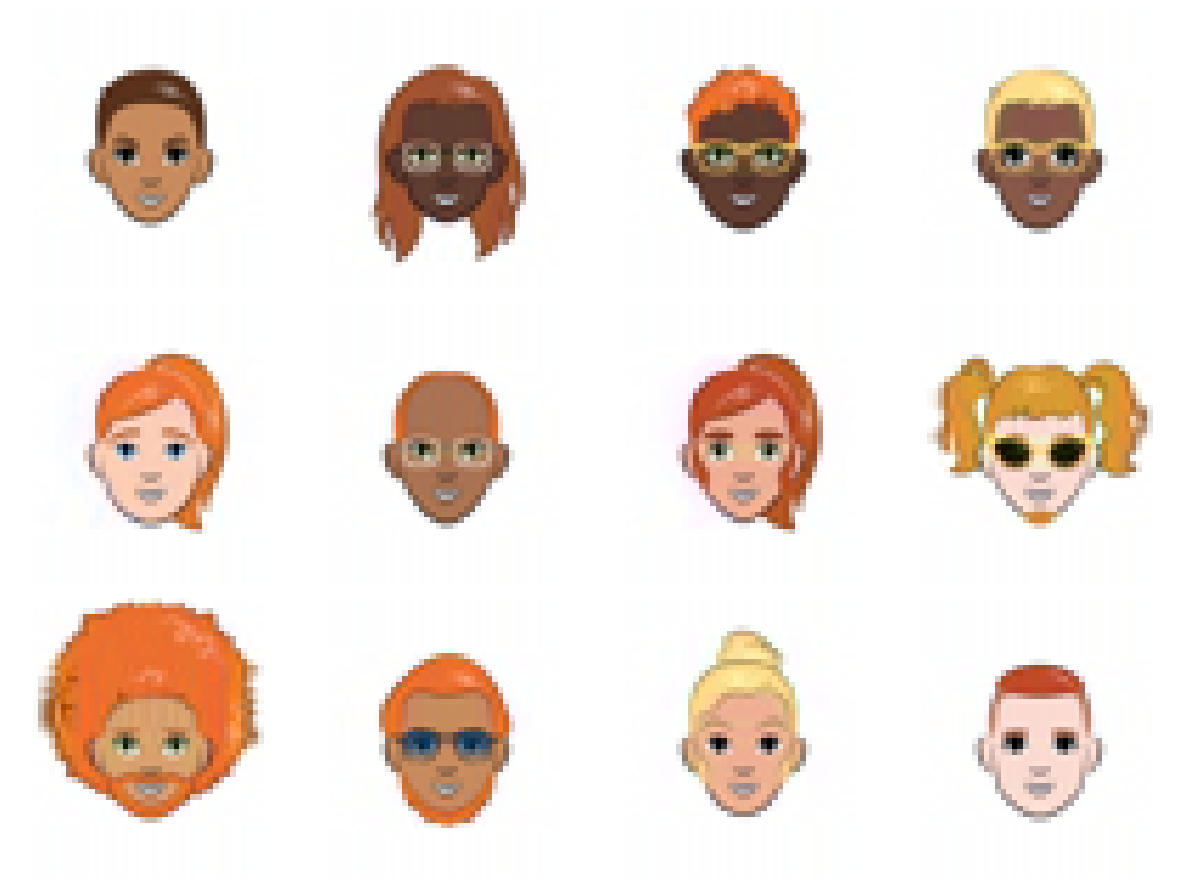

In [20]:
ig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))
axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(X_reconstructed[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()